# Evaluation Procedure
This walkthrough covers the `functime.evaluation` module, which contains functions to rank forecasts and time-series features (e.g. tsfresh).

## Forecasting
---

Let's score, rank, and plot point forecasts for multiple commodity prices. We compare two forecasting models:
- Seasonal naive (as our benchmark)
- AR (autoregressive) LightGBM model with local scaling

### Load data

In [1]:
%%capture
import polars as pl

from functime.cross_validation import train_test_split
from functime.evaluation import rank_point_forecasts, rank_fva, rank_residuals
from functime.forecasting import lightgbm, snaive
from functime.preprocessing import detrend
from functime.plotting import plot_forecasts, plot_comet, plot_residuals

In [2]:
fh = 12
y = pl.read_parquet("../../data/commodities.parquet")
entity_col = y.columns[0]
y_train, y_test = train_test_split(test_size=fh, eager=True)(y)
y.tail()

commodity_type,time,price
str,datetime[ns],f64
"""Zinc""",2022-11-01 00:00:00,2938.92
"""Zinc""",2022-12-01 00:00:00,3129.48
"""Zinc""",2023-01-01 00:00:00,3309.81
"""Zinc""",2023-02-01 00:00:00,3133.84
"""Zinc""",2023-03-01 00:00:00,2967.46


There are 71 unique commoditity types and 759 dates (monthly) between and 1960-01-01 and 2023-03-01.

In [3]:
y.select(
    pl.all().exclude("price").n_unique(),
    pl.col("time").min().dt.date().alias("start"),
    pl.col("time").max().dt.date().alias("end")
)

commodity_type,time,start,end
u32,u32,date,date
71,759,1960-01-01,2023-03-01


### Benchmark Forecasts

In [4]:
y_pred_bench = snaive(freq="1mo", sp=12)(y=y_train, fh=fh)
y_pred_bench.head()

commodity_type,time,price
str,datetime[μs],f64
"""Shrimps, Mexic…",2022-04-01 00:00:00,12.49
"""Shrimps, Mexic…",2022-05-01 00:00:00,12.65
"""Shrimps, Mexic…",2022-06-01 00:00:00,13.4
"""Shrimps, Mexic…",2022-07-01 00:00:00,15.86
"""Shrimps, Mexic…",2022-08-01 00:00:00,15.76


Let's plot the top 4 forecasts by **best** SMAPE score:

In [5]:
ranks = rank_point_forecasts(
    y_true=y_test,
    y_pred=y_pred_bench
)
ranks.head()

commodity_type,smape
str,f64
"""Gold""",0.016228
"""Tobacco, US im…",0.017253
"""Sugar, US""",0.02763
"""Groundnut oil …",0.027752
"""Cocoa""",0.027986


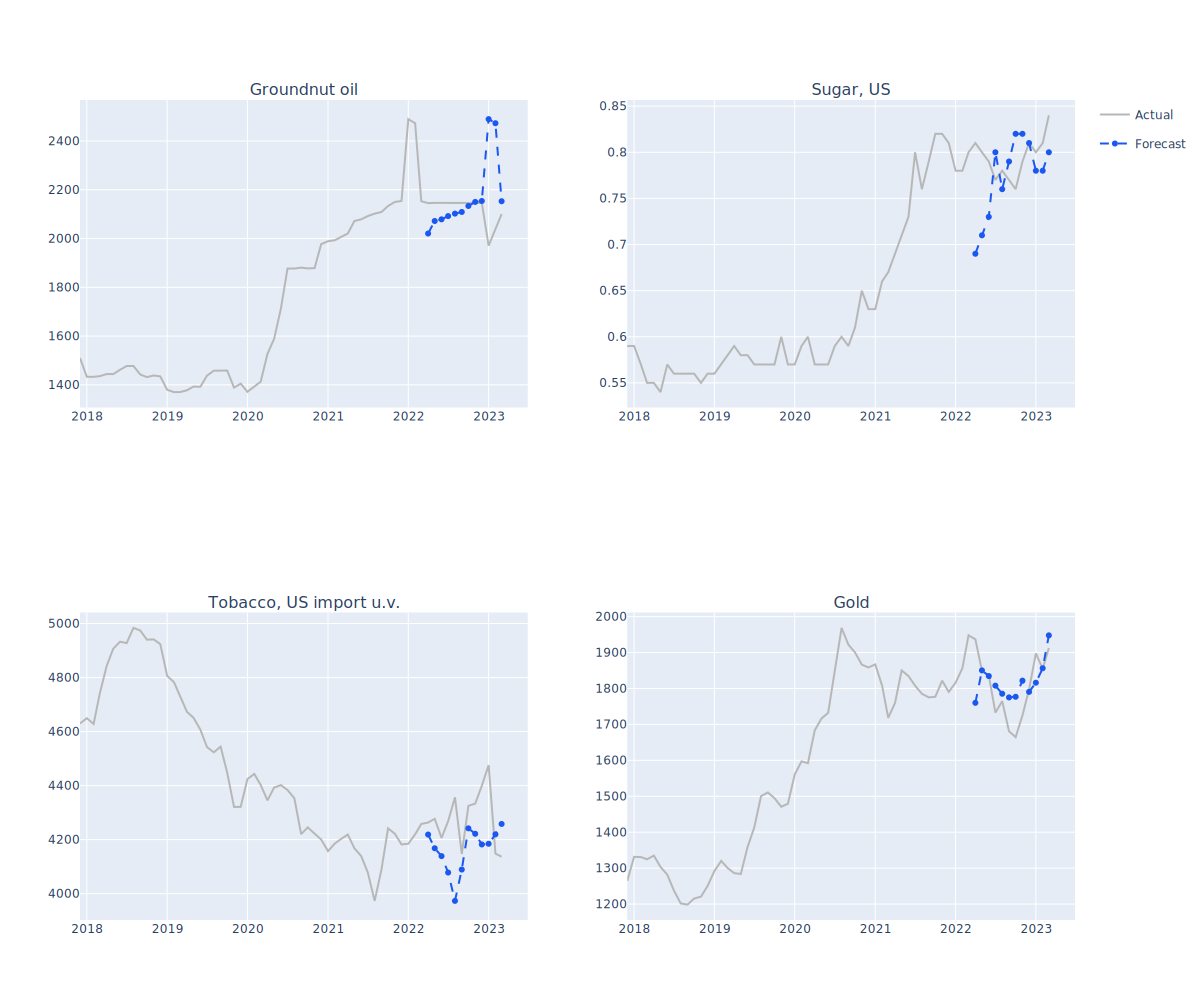

In [6]:
selected_entities = ranks.head(4).get_column(entity_col).unique()
figure = plot_forecasts(
    y_true=y.filter(pl.col(entity_col).is_in(selected_entities)),
    y_pred=y_pred_bench.filter(pl.col(entity_col).is_in(selected_entities)),
    n_cols=2,
    height=1000,
    width=1200
)
figure.show(renderer="svg")

Let's plot the top 3 forecasts by **worst** SMAPE score:

In [7]:
ranks = rank_point_forecasts(
    y_true=y_test,
    y_pred=y_pred_bench,
    descending=True
)
ranks.head()

commodity_type,smape
str,f64
"""Natural gas, E…",0.372189
"""Coal, Australi…",0.365411
"""Phosphate rock…",0.354421
"""Natural gas in…",0.328693
"""Coal, South Af…",0.28314


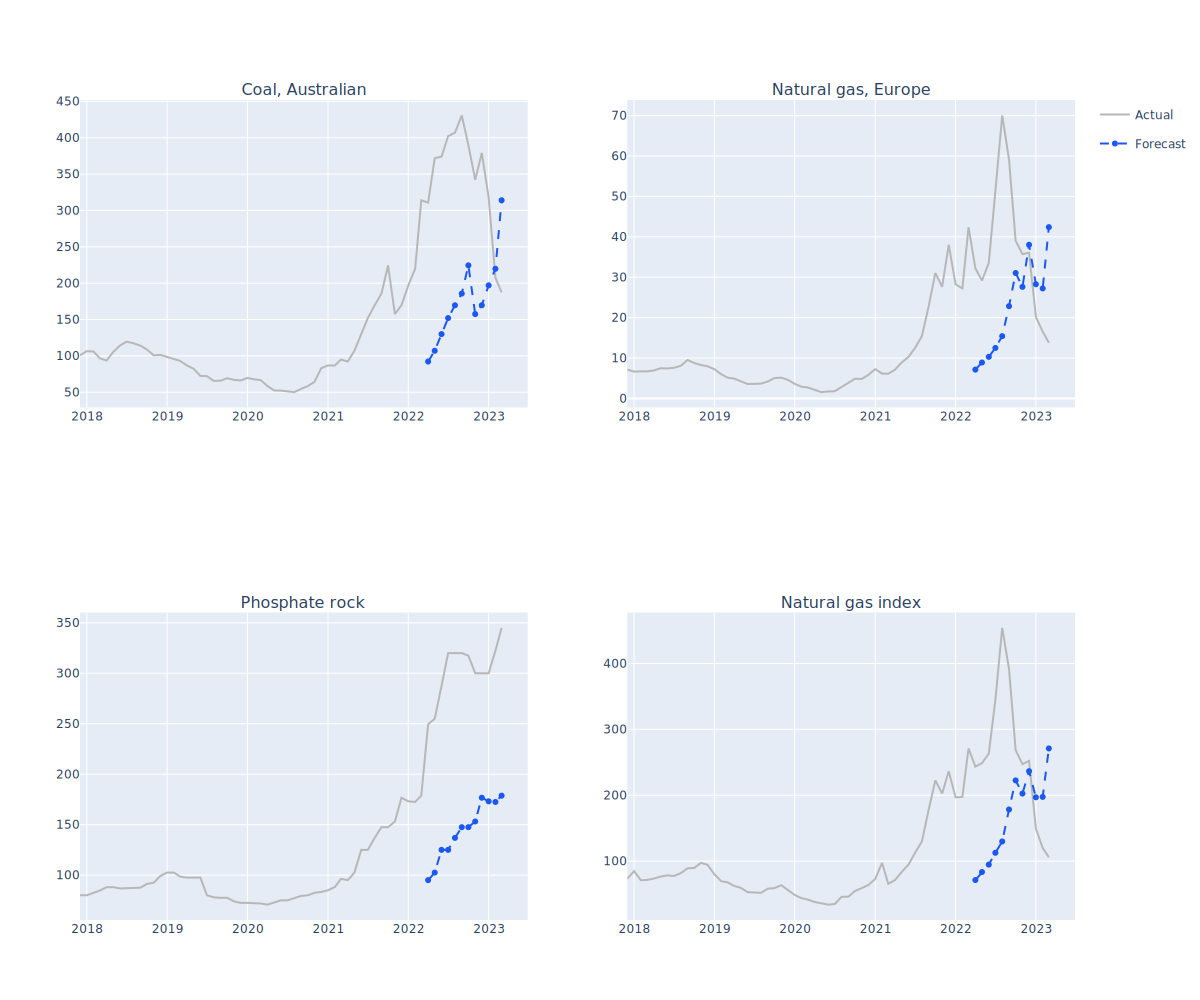

In [8]:
selected_entities = ranks.head(4).get_column(entity_col).unique()
figure = plot_forecasts(
    y_true=y.filter(pl.col(entity_col).is_in(selected_entities)),
    y_pred=y_pred_bench.filter(pl.col(entity_col).is_in(selected_entities)),
    n_cols=2,
    height=1000,
    width=1200
)
figure.show(renderer="svg")

### Global AR Forecasts

In [9]:
# Instantiate forecaster and backtest
forecaster = lightgbm(freq="1mo", lags=48, target_transform=detrend())
y_preds, y_resids = forecaster.backtest(
    y=y,
    test_size=12,
    step_size=12,
    n_splits=5
)

Let's plot backtests for commodities with the **best** SMAPE score across expanding window splits:

In [10]:
ranks = rank_point_forecasts(
    y_true=y,
    y_pred=y_preds,
)
ranks.head()

commodity_type,smape
str,f64
"""Lead""",0.047562
"""Rice, Thai 25%…",0.049113
"""Tea, avg 3 auc…",0.049359
"""Plywood""",0.050659
"""Logs, Malaysia…",0.053753


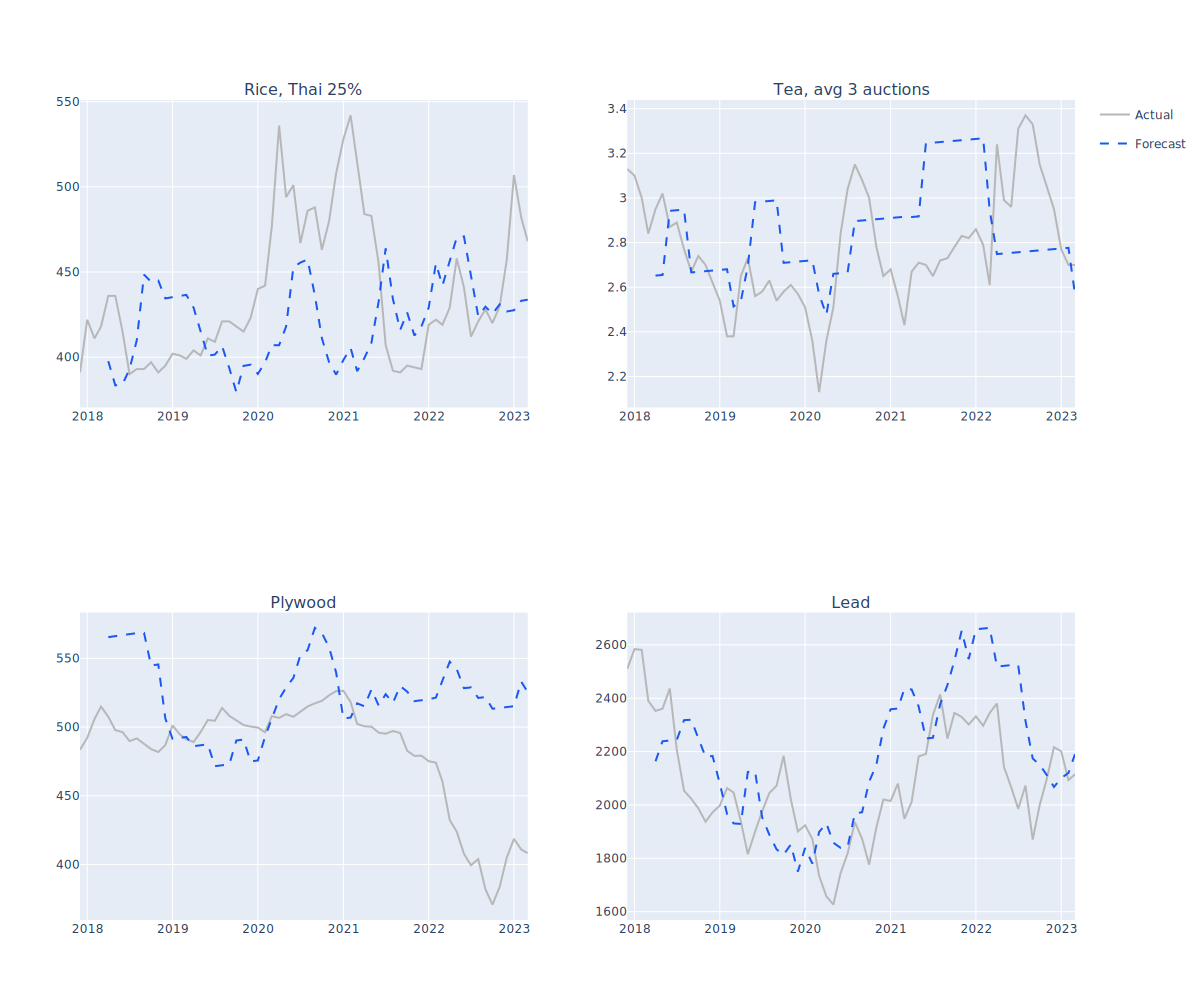

In [11]:
selected_entities = ranks.head(4).get_column(entity_col).unique()
figure = plot_forecasts(
    y_true=y.filter(pl.col(entity_col).is_in(selected_entities)),
    y_pred=y_preds.filter(pl.col(entity_col).is_in(selected_entities)),
    n_cols=2,
    height=1000,
    width=1200
)
figure.show(renderer="svg")

Let's plot backtests for commodities with the **worst** SMAPE score across expanding window splits:

In [12]:
ranks = rank_point_forecasts(
    y_true=y,
    y_pred=y_preds,
    descending=True
)
ranks.head()

commodity_type,smape
str,f64
"""Natural gas, E…",0.453647
"""Potassium chlo…",0.331863
"""Natural gas in…",0.31516
"""Coal, Australi…",0.306185
"""Phosphate rock…",0.289096


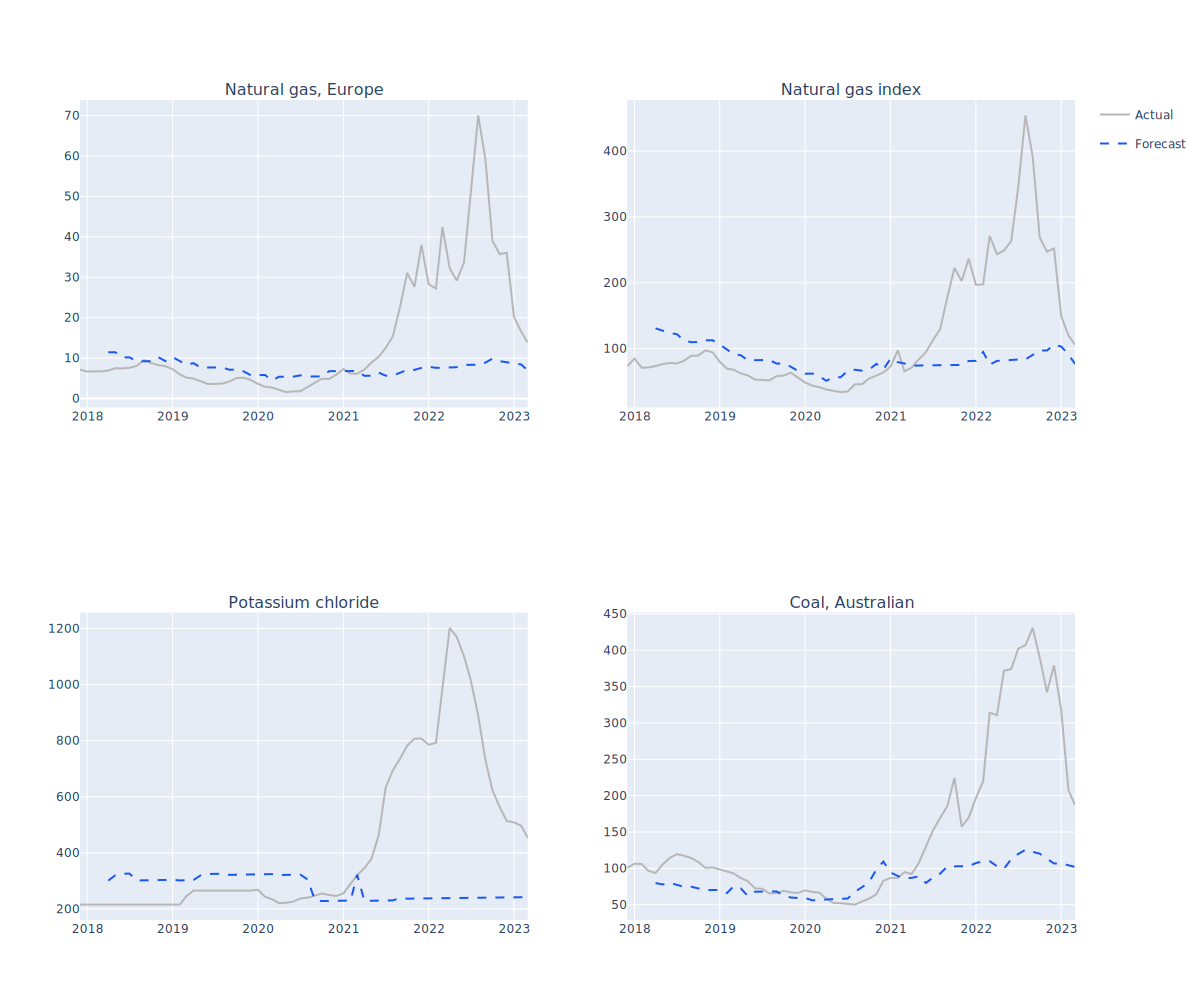

In [13]:
selected_entities = ranks.head(4).get_column(entity_col).unique()
figure = plot_forecasts(
    y_true=y.filter(pl.col(entity_col).is_in(selected_entities)),
    y_pred=y_preds.filter(pl.col(entity_col).is_in(selected_entities)),
    n_cols=2,
    height=1000,
    width=1200
)
figure.show(renderer="svg")

Let's plot residuals for top 10 forecasts ranked by highest mean absolute bias:

In [14]:
ranks = rank_residuals(
    y_resids=y_resids,
    sort_by="abs_bias",
    descending=True
)
ranks.head()

commodity_type,abs_bias
str,f64
"""Tin""",3647.285338
"""Nickel""",2888.592952
"""Zinc""",144.139823
"""Fish meal""",104.568748
"""Tobacco, US im…",101.051888


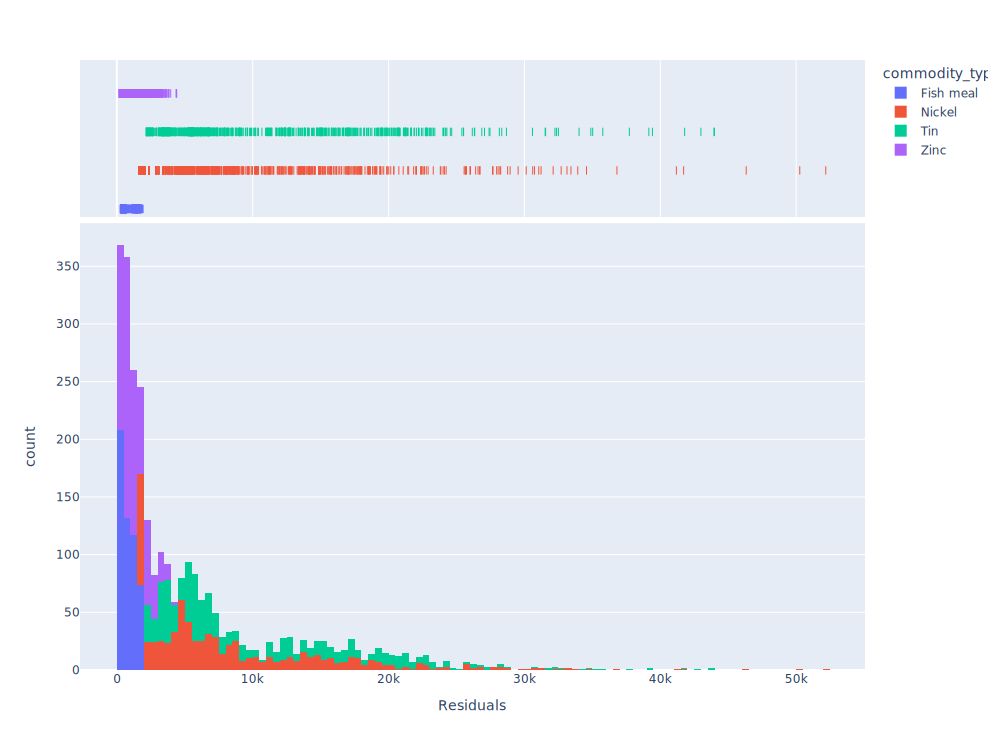

In [15]:
selected_entities = ranks.head(4).get_column(entity_col).unique()
figure = plot_residuals(
    y_resids=y.filter(pl.col(entity_col).is_in(selected_entities)),
    n_bins=200,
    height=750,
    width=1000
)
figure.show(renderer="svg")

Let's plot residuals for top 10 forecasts ranked by normality test with the null hypothesis that the residuals are normally distributed. Higher test statistic = more likely to reject null hypothesis under the assumption that the null is true.

In [16]:
ranks = rank_residuals(
    y_resids=y_resids,
    sort_by="normality",
    descending=True
)
ranks.head()

commodity_type,normal_test
str,f64
"""Natural gas, E…",4321.977586
"""Phosphate rock…",2351.334475
"""Potassium chlo…",2195.88077
"""Coal, Australi…",1917.223012
"""TSP""",1756.461335


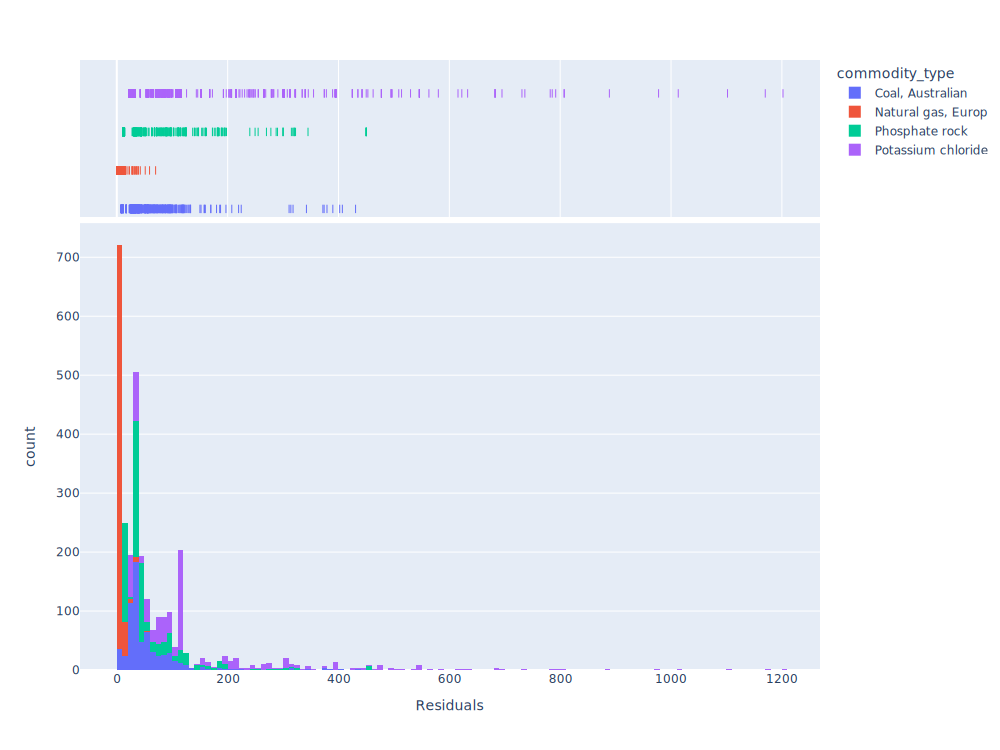

In [17]:
selected_entities = ranks.head(4).get_column(entity_col).unique()
figure = plot_residuals(
    y_resids=y.filter(pl.col(entity_col).is_in(selected_entities)),
    n_bins=200,
    height=750,
    width=1000
)
figure.show(renderer="svg")

## Feature Engineering
---
Coming soon.

## FFORMA (Feature-based Model Selection)
---
Coming soon.